# Chapter 4: Implementing a GPT model from Scratch To Generate Text

In [1]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [6]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.6
torch version: 2.4.0
tiktoken version: 0.7.0


In [3]:
# Configuration details for the 124 million parameter GPT-2 model include
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size, refers to a vocabulary of 50,257 words, as used by the BPE tokenizer
    "context_length": 1024, # Context length, denotes the maximum number of input tokens the model can handle via the positional embeddings
    "emb_dim": 768,         # Embedding dimension, is the embedding size for token inputs, converting each input token into a 768-dimensional vector
    "n_heads": 12,          # Number of attention heads, number of attention heads in the multi-head attention mechanism implemented in Chapter 3
    "n_layers": 12,         # Number of layers, number of transformer blocks within the model.
    "drop_rate": 0.1,       # Dropout rate, is the dropout mechanism's intensity.
    "qkv_bias": False       # Query-Key-Value bias
}

### Using this above  configuration, we will implement a GPT placeholder architecture (Dummy-GPTModel)

- these are the steps
- 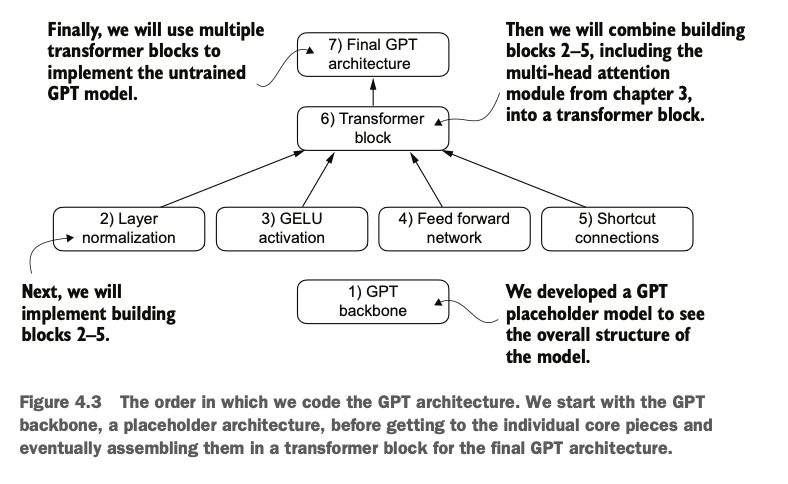

In [ ]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) # Token embedding layer vocab_size x emb_dim
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) # Positional embedding layer context_length x emb_dim
        self.drop_emb = nn.Dropout(cfg["drop_rate"]) 
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

# here in forward method, we will add token embeddings and positional embeddings, apply dropout, pass through transformer blocks, apply layer normalization, and finally project to vocabulary size to get logits.
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

Above code explained
- The DummyGPTModel class in this code defines a simplified version of a GPT-like
model using PyTorch’s neural network module `(nn.Module`).
It consist of below things
- 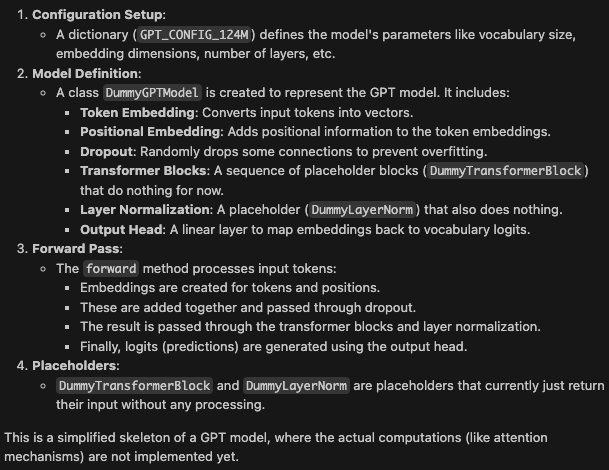

Next, we will prepare the input data and initialize a new GPT model to illustrate
its usage. Building on our coding of the tokenizer (see chapter 2), let’s now con-
sider a high-level overview of how data flows in and out of a GPT model, as shown in
figure 4.4.

- 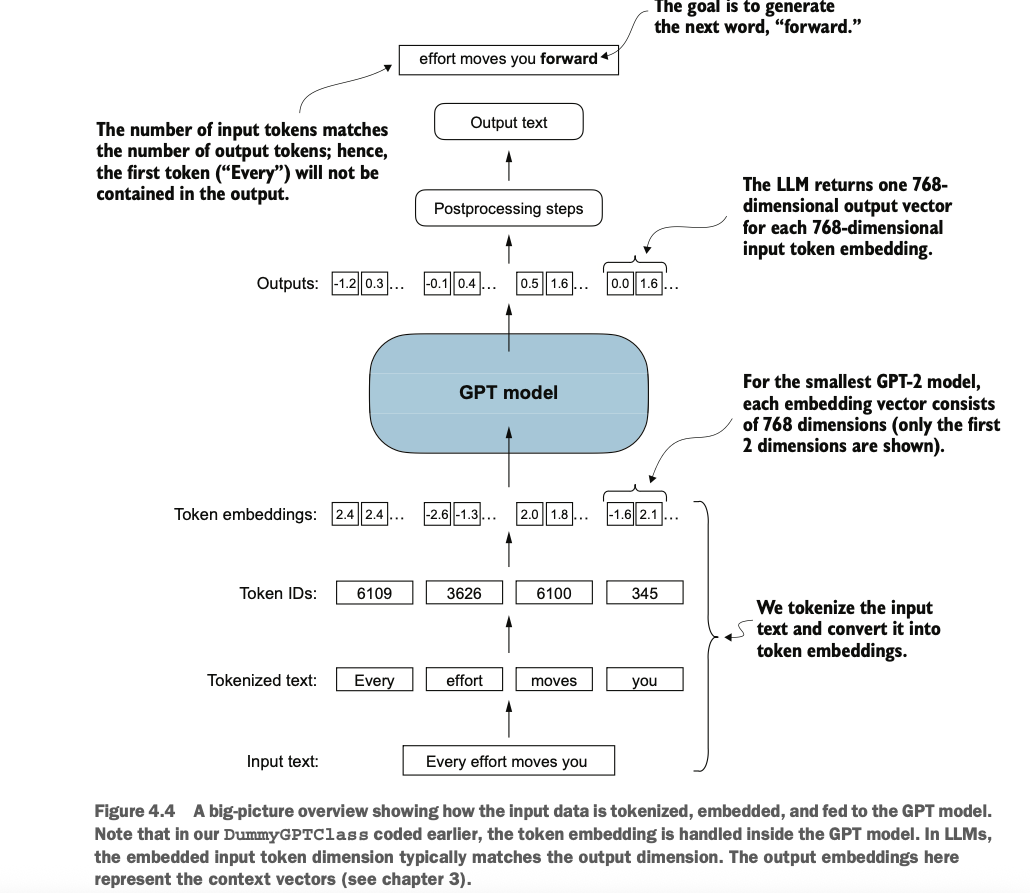

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)  # meaning of logist - output of the model before applying softmax, representing raw prediction scores for each token in the vocabulary.
# softmax - a mathematical function that converts a vector of raw scores (logits) into probabilities, ensuring that the probabilities sum to 1.
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


Output explanation 
- `Output`:
Shape of Output: (2, 4, 50257)
- `2`: Number of text samples in the batch.
- `4`: Number of tokens in each text sample.
- `50257`: Vocabulary size (each token is represented as a 50,257-dimensional vector).
- `Logits`: Raw scores for each token, which can later be converted to probabilities using softmax.

⭐⭐⭐
- Above we initialize a new 124-million-parameter DummyGPTModel instance and feed it the tokenized batch.
- The output tensor has two rows corresponding to the two text samples. Each text sample consists of four tokens; ⭐each token is a 50,257-dimensional vector, which matches the size of the tokenizer’s vocabulary.⭐
- The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary. When we implement the postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs, which we can then decode into words.

### 4.2 Normalizing activations with layer normalization
- Normalization is a technique used in deep learning to make the training process more stable and efficient. It adjusts the outputs (activations) of a layer so that they have a mean of 0 and a variance of 1. This helps the model learn faster and prevents issues like exploding or vanishing gradients.
- Now implement layer normalization to improve the stability and efficiency of neural network training.
- The main idea behind layer normalization is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also known as unit variance.
- In GPT-2 and modern transformer architectures, layer normalization is typically applied before and after the multi-head attention module.
- How its done? - 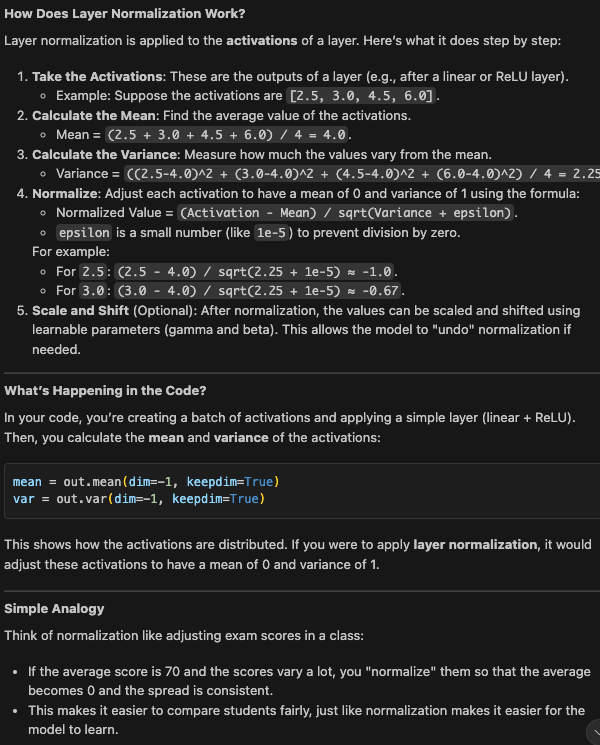

In [12]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [13]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [14]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
# This class implements layer normalization, which normalizes the input tensor x to have a mean of 0 and a variance of 1 along the last dimension.
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

### scale and shift 
please refer this for better understanding https://github.com/rasbt/LLMs-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb

In [16]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


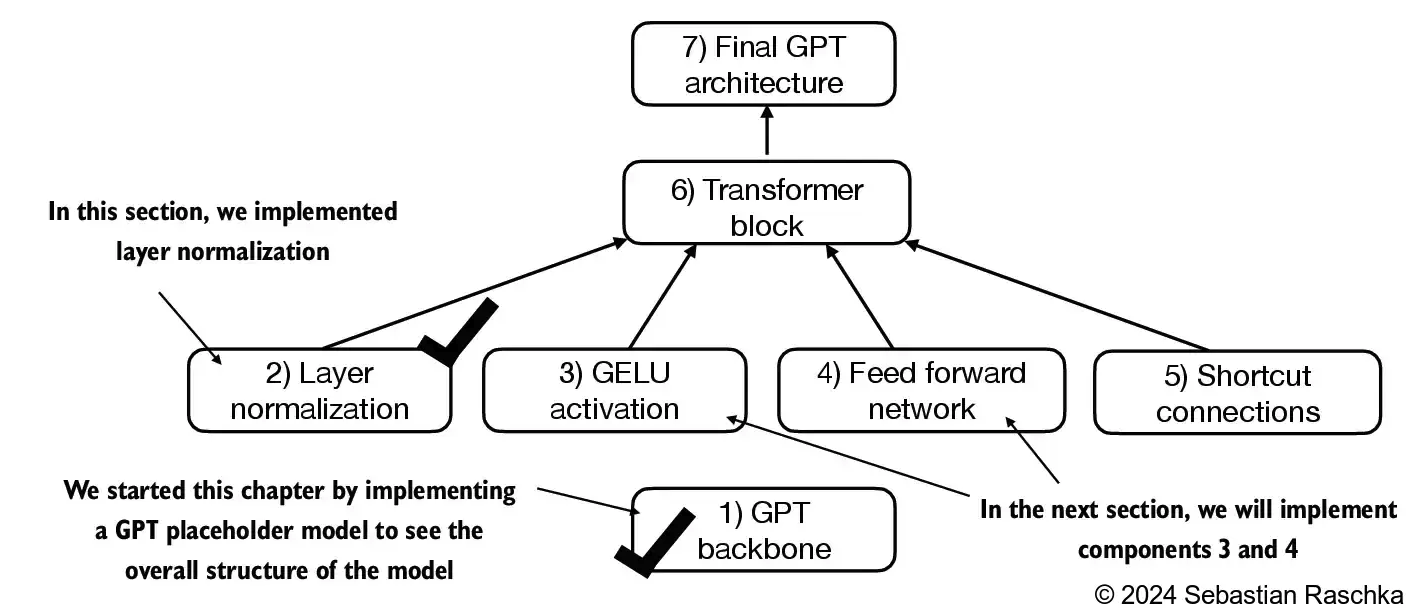

## 4.3 Implementing a feed forward network with GELU activations

In [17]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

Matplotlib is building the font cache; this may take a moment.


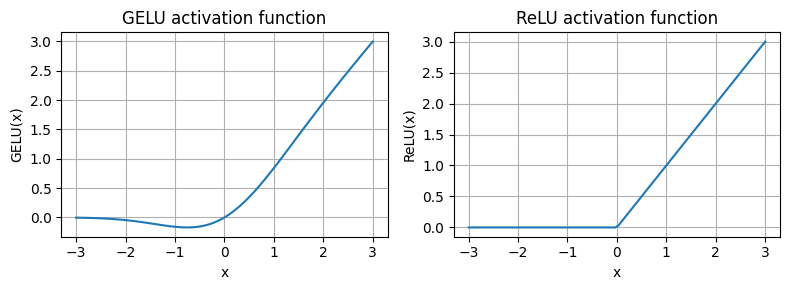

In [18]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

skipping last part here to mention as its too deep in math but you can refer that here https://github.com/rasbt/LLMs-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb

In [19]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits